In [2]:
import os
import psycopg2
from postgis.psycopg import register
import project_path
from db_importer.settings import *
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()
 
        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()

In [3]:
from shapely.geometry import Point
from shapely.geometry import box

start_rect = box(13.4155, 52.5213, 13.4167, 52.5219)
end_rect = box(13.4149, 52.5223, 13.4159, 52.5229)

def crop_intersection_SimRa(x):
    mask_first = x.coords.apply(lambda x: start_rect.contains(Point(x)))
    mask_end = x.coords.apply(lambda x: end_rect.contains(Point(x)))
    try:
        first = mask_first[mask_first==True].index[0]
        last = mask_end[mask_end==True].index[-1]
        return x.loc[first:last]
    except:
        print('check')
    
    
def crop_intersection_SUMO(x):
    mask_first = x.apply(lambda coord: start_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis = 1)
    mask_end = x.apply(lambda coord: end_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis = 1)
    try:
        first = mask_first[mask_first==True].index[0]
        last = mask_end[mask_end==True].index[-1]
        return x[['vehicle_x', 'vehicle_y']].loc[first:last].to_numpy()
    except:
        asasd = 12
        #print('check')
        

def plot_location(x, color, alpha, scatter):
    lon = []
    lat = []
    for c in x.coords.values:
        lon.append(c[0])
        lat.append(c[1])
    plt.plot(lon, lat, c=color, alpha=alpha)
    if scatter:
        zero_v_coords = x.apply(lambda x: x.coords if x.velos == 0 else None,axis = 1)
        lon = []
        lat = []
        for c in zero_v_coords.values:
            if c == None:
                continue
            lon.append(c[0])
            lat.append(c[1])
        plt.scatter(lon, lat)
        
        
def to_float_arr(x):
    res = []
    for c in x:
        res.append(float(c))
    return res


In [4]:
ped_files = ['VM2_-2112701535', 'VM2_-217686115','VM2_-1247665811','VM2_-104300786', 'VM2_330973206', 'VM2_1100569031', 'VM2_421371629', 'VM2_421371629', 'VM2_1476499235', 'VM2_-1451152685', 'VM2_-1523872256']


with DatabaseConnection() as cur:
    cur.execute("""
SELECT filename,
       json_array_elements_text(st_asgeojson(geom_raw) :: json -> 'coordinates') AS coordinates,
       unnest(timestamps)                             timestamps,
       unnest(velos)                                  velos
FROM ride
where st_intersects(geom, st_setsrid(
        st_makebox2d(st_makepoint(13.4159, 52.5209), st_makepoint(13.4164, 52.5216)), 4326))
  AND st_intersects(geom, st_setsrid(
        st_makebox2d(st_makepoint(13.4157, 52.5224), st_makepoint(13.4164, 52.5227)), 4326))
  AND timestamps[1] < '2021-01-01 00:00:00'""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'coords', 'timestamps', 'velos'])
    df = df[~df.coords.isnull()]
    df = df[~df['filename'].isin(ped_files)]
    df.coords = df.coords.apply(lambda x: x.replace('[', '').replace(']', '').split(','))
    df.coords = df.coords.apply(lambda x: to_float_arr(x))
    
    grouped = df.groupby('filename', as_index=False)
    df_simra = grouped.apply(lambda x: crop_intersection_SimRa(x))


In [5]:
df_default = pd.read_csv('../sim_data/alex_default.csv', delimiter=';')    
df_im = pd.read_csv('../sim_data/alex_im.csv', delimiter=';')    

dfs=[df_default, df_im]

df_data = []
for df in dfs:
    res = df.groupby('vehicle_id').apply(lambda x: crop_intersection_SUMO(x)).dropna()
    df_data.append(res.to_numpy())
    

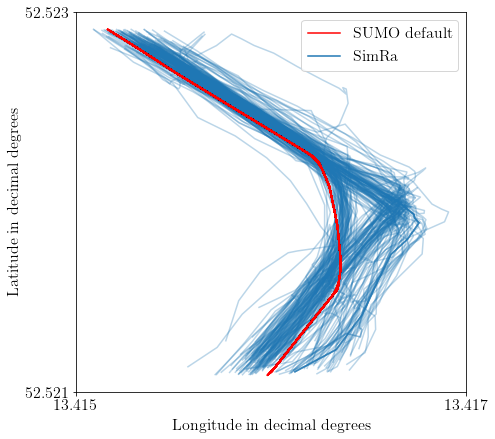

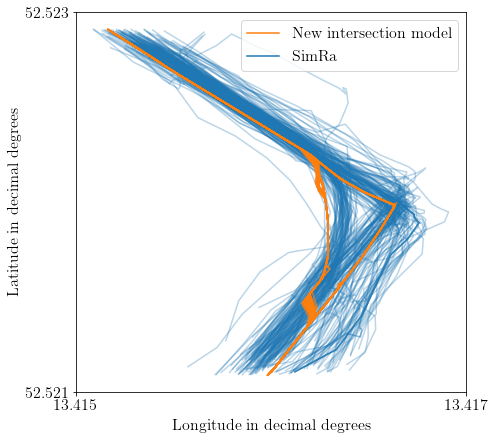

In [10]:
from matplotlib import rc

map_data = plt.figure(figsize=(7,7))

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']

df_simra.groupby('filename').apply(lambda x: plot_location(x, colors[0], 0.3, False))
for ride in df_data[0]:
    plt.plot(ride[:,0], ride[:,1],c ='r', alpha=.7)


xmin, xmax, ymin, ymax = plt.axis()
plt.xticks([xmin, xmax], [round(xmin, 3), round(xmax, 3)])
plt.xlabel('Longitude in decimal degrees')
plt.yticks([ymin, ymax], [round(ymin, 3), round(ymax, 3)])
plt.ylabel('Latitude in decimal degrees')
plt.plot([], c='r', label='SUMO default')
plt.plot([], c=colors[0], label='SimRa')
plt.legend(loc='upper right')
plt.savefig('images/im_alex_default_simra_loc.png', dpi=300, bbox_inches='tight')
plt.show()

map_data = plt.figure(figsize=(7,7))
df_simra.groupby('filename').apply(lambda x: plot_location(x, colors[0], 0.3, False))
for ride in df_data[1]:
    plt.plot(ride[:,0], ride[:,1],c =colors[1], alpha=.7)
xmin, xmax, ymin, ymax = plt.axis()
plt.xticks([xmin, xmax], [round(xmin, 3), round(xmax, 3)])
plt.xlabel('Longitude in decimal degrees')
plt.yticks([ymin, ymax], [round(ymin, 3), round(ymax, 3)])
plt.ylabel('Latitude in decimal degrees')
plt.plot([], c=colors[1], label='New intersection model')
plt.plot([], label='SimRa')
plt.legend(loc='upper right')
plt.savefig('images/im_alex_im_simra_loc.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
## Damit der läuft, muss die Legend aus den Plots ausgespart werden. Bug seitens mplleaflet.
import mplleaflet
#mplleaflet.display(fig=map_data)
mplleaflet.show(fig=map_data)

AttributeError: 'XAxis' object has no attribute '_gridOnMajor'